In [1]:
import numpy as np
import matplotlib.pyplot as plt
#import BstoK_ref_ff as BstoK
import h5py as h5
from tqdm import tqdm
import masses

In [2]:
datasetisrome = False

datatlist = np.linspace(23.5,17.5,3)#[23.72835562, 21.15623588, 17.5]#np.array([23.7283556,22.11456,20.07895,17.5000000])#np.linspace(23.5,17.5,n)
maxplott = max(datatlist)+1
n = len(datatlist)
nplus = n
nzero = n

def ff_E(Evec,pole,coeff):
  # construct ff from HMChPT in continuum limit
  return [1./(E+pole)*np.sum([E**i*coeff[i] for i in range(len(coeff))]) for E in Evec]
def cov_ff_p0(Evec_p,Evec_0,C,Np,N0,pole_p,pole_0):
  # construct covariance matrix for ff from HMChPT in continuum limit
  Y_E_p_vec   	= lambda E_p: np.r_[ np.array([1./(E_p+pole_p)*E_p**i for i in range(Np)])]
  Y_E_0_vec   	= lambda E_0: np.r_[ np.array([1./(E_0+pole_0)*E_0**i for i in range(N0)])]
  Cpp		= np.array([[np.dot(Y_E_p_vec(E1),np.dot(C[:Np,:Np],Y_E_p_vec(E2)))
					for E1 in Evec_p] for E2 in Evec_p])
  C00		= np.array([[np.dot(Y_E_0_vec(E1),np.dot(C[Np:,Np:],Y_E_0_vec(E2)))
					for E1 in Evec_0] for E2 in Evec_0])
  Cp0		= np.array([[np.dot(Y_E_p_vec(E1),np.dot(C[:Np:,Np:],Y_E_0_vec(E2)))
					for E1 in Evec_p] for E2 in Evec_0])
  M0		= np.r_['-1',Cpp  ,Cp0.T]
  M1		= np.r_['-1',Cp0  ,C00  ]
  M		= np.r_[M0,M1]
  return M

# define kinematics
mKphys		= masses.mK
mBsphys		= masses.mBs
#
qsq_refK	= np.array(datatlist)#np.array([23.7283556,22.11456,20.07895,17.5000000]) # you can choose this freely np.array(np.linspace(23.5,17.5,7))
#
ksq_refK 	= (mBsphys**4+(mKphys**2-qsq_refK)**2-2*mBsphys**2*(mKphys**2+qsq_refK))/(4*mBsphys**2)
ErefK 	 	= np.sqrt(mKphys**2+ksq_refK)
Deltapar	= + 0.263
Deltaperp	= - 0.0416


f=h5.File('BstoK_ref_ff_dat.hdf5','r')
cp_BstoK=np.array(f.get('cp'))
c0_BstoK=np.array(f.get('c0'))
Cp0_BstoK=np.array(f.get('Cp0'))
fp_BstoK 	= np.array(ff_E(ErefK,Deltaperp,cp_BstoK))
f0_BstoK 	= np.array(ff_E(ErefK,Deltapar ,c0_BstoK))
ff_ref		= np.r_[ fp_BstoK, f0_BstoK]
Cp0_ref 	= cov_ff_p0(ErefK,ErefK,Cp0_BstoK,2,3,Deltaperp,Deltapar)
# some IO

qsqinputl = datatlist
bskpts = np.r_[fp_BstoK,f0_BstoK]
bskcov = np.array(Cp0_ref)


chi0plus = 1.48e-02
chi1minus = 6.03e-04
chiplus = chi1minus
chizero = chi0plus

##### "Rome data" #####

romedata = np.array([[1.3461, 1.102, 0.911],
[1.6154, 1.208, 0.944],
[1.8846, 1.336, 0.979]]) #rome form factor data, plus = 1, zero = 2

romedataplus = np.array([[1.3461, 1.102],
[1.6154, 1.208],
[1.8846, 1.336]])

romedatazero = np.array([[1.3461, 0.911],
[1.6154, 0.944],
[1.8846, 0.979]])


######################################################################


tstar = 29.349571
t0 = 16.505107
tplus = 34.368484
tminus = 23.728356

dataplus=np.transpose(np.array([qsqinputl,
bskpts[0:nplus]]))

datazero=np.transpose(np.array([qsqinputl,
bskpts[nplus:]]))

totaldata = [datazero,dataplus]
chizerovar = 0
chiplusvar = 0
eta = 1
covmatrix = bskcov
polevalszero = []
polevalsplus = [5.324700**2]

if datasetisrome:
    maxplott = 2
    datazero = romedatazero
    dataplus = romedataplus
    totaldata = [datazero,dataplus]
    #chizerovar = 0.00133
    #chiplusvar = 0.00036
    tminus = 1.8846
    tplus = 5.588946789081293
    tstar = tplus
    t0 = tminus
    eta = 2
    nplus=3
    nzero=3
    polevalszero = [2.3178**2]
    polevalsplus = [2.1122**2]
    covmatrix = np.array([[0.0003728 , 0.00035185, 0.00032986, 0.00062943, 0.00068001,
        0.00074066],
       [0.00035185, 0.00035141, 0.00035093, 0.00059243, 0.00066987,
        0.0007647 ],
       [0.00032986, 0.00035093, 0.00037308, 0.00055355, 0.00065922,
        0.00078995],
       [0.00062943, 0.00059243, 0.00055355, 0.00143986, 0.00165246,
        0.00191377],
       [0.00068001, 0.00066987, 0.00065922, 0.00165246, 0.0019623 ,
        0.00234545],
       [0.00074066, 0.0007647 , 0.00078995, 0.00191377, 0.00234545,
        0.00288136]])
    bskpts = []
    for subdata in [dataplus,datazero]:
        for counter in range(3):
            bskpts.append(subdata[counter,1])

In [3]:
totaldata

[array([[23.5       ,  0.85344367],
        [20.5       ,  0.64020154],
        [17.5       ,  0.49003301]]),
 array([[23.5       ,  2.98319516],
        [20.5       ,  1.61986464],
        [17.5       ,  0.99334338]])]

In [4]:
def covresample(bskpts):
    bskpts_resampled = np.random.multivariate_normal(bskpts,covmatrix)
    dataplustlist = []
    for i in range(len(dataplus)):
        dataplustlist.append(dataplus[i][0])
    
    plus = np.array([dataplustlist,
    bskpts_resampled[0:nplus]])
    plus=np.transpose(plus)

    datazerotlist = []
    for i in range(len(datazero)):
        datazerotlist.append(datazero[i][0])
    zero = np.array([datazerotlist,
    bskpts_resampled[nplus:]])
    zero=np.transpose(zero)
    return [zero,plus]

In [5]:
totaldata

[array([[23.5       ,  0.85344367],
        [20.5       ,  0.64020154],
        [17.5       ,  0.49003301]]),
 array([[23.5       ,  2.98319516],
        [20.5       ,  1.61986464],
        [17.5       ,  0.99334338]])]

In [6]:
covresample(bskpts)

[array([[23.5       ,  0.8691229 ],
        [20.5       ,  0.64595198],
        [17.5       ,  0.49719013]]),
 array([[23.5       ,  3.02112909],
        [20.5       ,  1.65711518],
        [17.5       ,  1.03027988]])]

In [8]:
def z(t):
    return (np.sqrt(tstar-t)-np.sqrt(tstar - t0))/(np.sqrt(tstar-t)+np.sqrt(tstar - t0))

In [9]:
z(0)

0.20370147989383297

In [9]:
def phiplus(t,chi = chiplus):
    #chi = 1
    K = 48*np.pi
    a = 3
    b = 2
    rq = np.sqrt(tstar-t)
    rminus = np.sqrt(tstar-tminus)
    r0 = np.sqrt(tstar-t0)
    val = np.sqrt(eta/(K*chi))*(rq**((a+1)/2))*r0**(-1/2)*(rq+r0)*((rq+np.sqrt(tstar))**(-b-3))*(rq+rminus)**(a/2)
    for i in range(len(polevalsplus)):
        val *= (z(t)-z(polevalsplus[i]))/(1-np.conjugate(z(polevalsplus[i]))*z(t))
    return val

In [10]:
def phizero(t,chi = chizero):
    #chi = 1
    K = 16*np.pi/(tplus*tminus)
    a = 1
    b = 1
    rq = np.sqrt(tstar-t)
    rminus = np.sqrt(tstar-tminus)
    r0 = np.sqrt(tstar-t0)
    val = np.sqrt(eta/(K*chi))*(rq**((a+1)/2))*r0**(-1/2)*(rq+r0)*((rq+np.sqrt(tstar))**(-b-3))*(rq+rminus)**(a/2)
    for i in range(len(polevalszero)):
        val *= (z(t)-z(polevalszero[i]))/(1-np.conjugate(z(polevalszero[i]))*z(t))
    return val

In [11]:
def exclude(G,a,b):
    return np.delete(np.delete(G,b,0),a,1)

In [12]:
def G(data,t):
    row = [t]
    row.extend(data[:,0])
    #print(row)
    mat = np.empty([data.shape[0]+1,data.shape[0]+1])

    for i in range(len(row)):
        for j in range(len(row)):
            mat[i,j] = 1/(1-z(row[i])*z(row[j]))
    return mat

In [13]:
def Gdiag(G):
    #print(G)
    tempresult = np.linalg.svd(G)
    D = np.diag(tempresult[1])
    U = np.transpose(np.array(tempresult[0]))
    return [D,U]

In [14]:
def alpha(data,t):
    ssum = 0
    temp = Gdiag(G(data,t))
    U = temp[1]
    D = temp[0]
    for i in range(0,data.shape[0]+1):
        ssum += U[i,0]*U[i,0]/D[i,i]
    return ssum

In [15]:
def beta(data, t, phi,chi):
    ssum = 0
    temp = Gdiag(G(data,t))
    U = temp[1]
    D = temp[0]
    for i in range(0,data.shape[0]+1):
        for j in range(1,data.shape[0]+1):
            ssum += U[i,j]*data[j-1,1]*phi(data[j-1,0],chi)*U[i,0]/D[i,i]
    return ssum

In [16]:
def gamma(data, t,phi,chi):
    temp = Gdiag(G(data,t))
    U = temp[1]
    D = temp[0]
    ssum = 1
    for i in range(0,data.shape[0]+1):
        for j in range(1,data.shape[0]+1):
            for k in range(1,data.shape[0]+1):
                ssum -= U[i,j]*data[j-1,1]*phi(data[j-1,0],chi)*U[i,k]*data[k-1,1]*phi(data[k-1,0],chi)/D[i,i]
    return ssum

In [17]:
def formfactor_unordered(data,t,chi=[chizero,chiplus]):
    results = []
    datazero = data[0]
    dataplus = data[1]
    chizero = chi[0]
    chiplus = chi[1]
    
    
    for dindex in [0,1]:
        ssum = 0
        tempdata = data[dindex]
        phi = [phizero,phiplus][dindex]
        
        
        calcalpha = alpha(tempdata,t)
        #print(tempdata,t,phi,chi[dindex])
        calcbeta = beta(tempdata,t,phi,chi[dindex])
        calcgamma = gamma(tempdata,t,phi,chi[dindex])
        #print(calcalpha,calcbeta,calcgamma)
        [D,U] = Gdiag(G(tempdata,t))
        #print(D,U)
        phif = tempdata[:,1]*phi(tempdata[:,0])
        for i in range(0,tempdata.shape[0]):
            for j in range(i+1,tempdata.shape[0]+1):
                for k in range(1,tempdata.shape[0]+1):
                    #print(U.shape,phif.shape)
                    C1 = 2*U[i,0]*U[i,k]*U[j,0]*U[j,1:]
                    C2 = U[i,0]*U[i,0]*U[j,k]*U[j,1:]
                    C3 = U[j,0]*U[j,0]*U[i,k]*U[i,1:]
                    ssum += phif[:]*phif[k-1]*(C1 - C2 - C3)/(D[i,i]*D[j,j]) # add to list and sort
        discrim = sum(ssum) + calcalpha
        if discrim < 0:
            print("discriminant is negative: ",discrim,calcbeta**2+calcalpha*calcgamma)
            discrim = 0
        lowerbound = (-calcbeta-np.sqrt(discrim))/(calcalpha*phi(t))
        upperbound = (-calcbeta+np.sqrt(discrim))/(calcalpha*phi(t))
        results.append([lowerbound,upperbound])
    return results

In [18]:
def sort_list(numlist):
    return np.flip(sorted(numlist, key = abs))

In [19]:
sort_list([1,-8,3,4,-5,2])

array([-8, -5,  4,  3,  2,  1])

In [2]:
def formfactor(data,t,chi=[chizero,chiplus],poslist = None,neglist = None):
    results = []
    datazero = data[0]
    dataplus = data[1]
    chizero = chi[0]
    chiplus = chi[1]
    
    
    
    for dindex in [0,1]:
        ssum = []
        tempdata = data[dindex]
        phi = [phizero,phiplus][dindex]
        
        
        calcalpha = alpha(tempdata,t)
        #print(tempdata,t,phi,chi[dindex])
        calcbeta = beta(tempdata,t,phi,chi[dindex])
        calcgamma = gamma(tempdata,t,phi,chi[dindex])
        #print(calcalpha)#,calcbeta,calcgamma
        [D,U] = Gdiag(G(tempdata,t))
        #print(D,U)
        phif = tempdata[:,1]*phi(tempdata[:,0])
        for i in range(0,tempdata.shape[0]):
            for j in range(i+1,tempdata.shape[0]+1):
                for k in range(1,tempdata.shape[0]+1):
                    for l in range(1,tempdata.shape[0]+1):
                        #print(U.shape,phif.shape)
                        C1 = 2*U[i,0]*U[i,k]*U[j,0]*U[j,l]
                        C2 = U[i,0]*U[i,0]*U[j,k]*U[j,l]
                        C3 = U[j,0]*U[j,0]*U[i,k]*U[i,l]
                        ssum.append(phif[l-1]*phif[k-1]*(C1 - C2 - C3)/(D[i,i]*D[j,j]))  # add to list and sort
        ssum.append(calcalpha)
        summand = sort_list(ssum)
        discrim = 0
        for i in range(len(ssum)):
            discrim += summand[i]
        #print("Order of magnitude diff = ",np.log10(abs(summand[0])),np.log10(abs(summand[-1])),np.log10(abs(discrim)))
        if discrim < 0:
            if neglist is not None:
                neglist.append([np.log10(abs(summand[0])),discrim,dindex])
            #print("^discriminant is negative: ",discrim)
        elif poslist is not None:
            poslist.append([np.log10(abs(summand[0])),discrim,dindex])
        
        if abs(discrim/summand[0]) < 10**-10:
            discrim = 0
        #print([D,U])
        lowerbound = (-calcbeta-np.sqrt(discrim))/(calcalpha*phi(t))
        upperbound = (-calcbeta+np.sqrt(discrim))/(calcalpha*phi(t))
        results.append([lowerbound,upperbound])
    return results

NameError: name 'chizero' is not defined

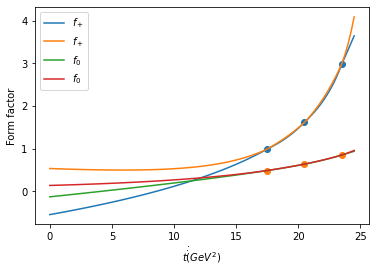

In [21]:
x = np.linspace(0,maxplott,101)
plt.plot(x,[formfactor(totaldata,i)[1] for i in x],label = r"$f_+$")
plt.plot(x,[formfactor(totaldata,i)[0] for i in x],label = r"$f_0$")
plt.scatter(dataplus[:,0],dataplus[:,1])
plt.scatter(datazero[:,0],datazero[:,1])

plt.xlabel(r"$t \.\.(GeV^2)$")
plt.ylabel("Form factor")
plt.legend()
plt.rcParams["figure.figsize"] = (20,20)
plt.show()

In [29]:
def dispbounds(tlist,Nboot,N0=10,keepallindexresults=False,seed=None,NSdebug = False):
    np.random.seed(seed=seed)
    if N0 < 2:
        print("N0 must have a value of at least 2")
        return
    
    if NSdebug == True:
        poslist = []
        neglist = []
    else:
        poslist = None
        neglist = None
    
    nooverlapcount = 0
    unitarityfailcount = 0
    totalresults = []
    poslist = []
    neglist = []
    for i in tqdm(range(Nboot)):
        #print(bskpts)
        resampleddata = covresample(bskpts)
        #print(resampleddata)
        resampledchi = [np.random.normal(chizero,0),np.random.normal(chiplus,0)]#chizerovar,chiplusvar
        #print("about to resample zero bounds")
        resamplezerobounds = formfactor(resampleddata,0,resampledchi)#,poslist = poslist, neglist = neglist
        #print("finished resampling zero bounds")
        if resamplezerobounds[0][0]>resamplezerobounds[1][1] or resamplezerobounds[0][1]<resamplezerobounds[1][0]:
            print("No Overlap")
            nooverlapcount += 1
            continue
        elif resamplezerobounds[0][0]==resamplezerobounds[0][1] or resamplezerobounds[1][0]==resamplezerobounds[1][1]:
            unitarityfailcount += 1
            continue
        lower = max(resamplezerobounds[0][0],resamplezerobounds[1][0])
        upper = min(resamplezerobounds[0][1],resamplezerobounds[1][1])
        
        indexlist = np.linspace(0,N0-1,N0,dtype=int)#index can take values from 0 to N0-1
        #print(indexlist)
        tempboundslist = np.zeros([len(tlist),len(indexlist)],dtype=object)
        for index in indexlist:
            fval = lower+(upper-lower)*index/(N0-1)
            erdata = [0,0]
            #print(resampleddata[0],resampleddata[1])
            erdata[0] = np.vstack([resampleddata[0],[0,fval]])
            erdata[1] = np.vstack([resampleddata[1],[0,fval]])
            counter = 0
            #print(erdata)
            for t in tlist:
                tempbounds = formfactor(erdata,t,resampledchi,poslist = poslist, neglist = neglist)
                #print("Hello")
                tempboundslist[counter,index] = tempbounds
                counter += 1
        #print(tempboundslist)
        if keepallindexresults==False:
            results = np.zeros([len(tlist)],dtype=object)
            for tindex in range(len(tlist)):
                #print(tindex)
                results[tindex] = tempboundslist[tindex,0]
                for index in range(1,len(indexlist)):
                    a = results[tindex]
                    b = tempboundslist[tindex,index]
                    results[tindex] = [[min(a[0][0],b[0][0]),max(a[0][1],b[0][1])],[min(a[1][0],b[1][0]),max(a[1][1],b[1][1])]]
        elif keepallindexresults==True:
            results = tempboundslist #results structured as results[index][timeindex][f0/f+][lower/upper]
        
        totalresults.append(results)#results structured as results[Nboot][index][timeindex][f0/f+][lower/upper]
    if nooverlapcount + unitarityfailcount > 0:
        print(nooverlapcount,unitarityfailcount)
    
    if len(poslist)+len(neglist) > 0 and NSdebug == True:
        for dindex in [0,1]:
            plt.scatter([x[0] for x in poslist if x[2] == dindex],[x[1] for x in poslist if x[2] == dindex])
            plt.scatter([x[0] for x in neglist if x[2] == dindex],[x[1] for x in neglist if x[2] == dindex])
    #         maxx = max(max([x[0] for x in poslist if x[2] == dindex]),max([x[0] for x in neglist if x[2] == dindex]))
    #         minx = min(min([x[0] for x in poslist if x[2] == dindex]),min([x[0] for x in neglist if x[2] == dindex]))
    #         plt.hist([x[0] for x in poslist if x[2] == dindex],bins=20,range = (minx,maxx),color="blue", alpha=0.5)
    #         plt.hist([x[0] for x in neglist if x[2] == dindex],bins=20,range = (minx,maxx),color="red", alpha=0.5)
            plt.show()
    return [tlist,totalresults,Nboot-nooverlapcount]

In [23]:
#calculating final values from bootstrap results
def calcbounds(output):
    results = np.zeros([len(output[0]),2],dtype=object)
    for tindex in range(len(output[0])):
        tempresult=[]
        for dindex in [0,1]:
            tchosen = output[0][tindex]
            data = np.zeros([output[2],2])
            for boot in range(output[2]):
                data[boot,0] = output[1][boot][tindex][dindex][0]
                data[boot,1] = output[1][boot][tindex][dindex][1]
            #print(data)
            averageff = (0.5*(np.nanmean(data[:,0])+np.nanmean(data[:,1])))
            delta = [data[:,0]-averageff,data[:,1]-averageff]
            varlo = np.sum(delta[0]**2)/(len(delta[0])-1)
            varup = np.sum(delta[1]**2)/(len(delta[1])-1)
            rho = np.dot(delta[0],delta[1])/(len(delta[0])-1)
            var = (np.nanmean(data[:,0])-np.nanmean(data[:,1]))**2/12 + (varlo+varup+rho)/3
            std = np.sqrt(var)
            tempresult.append([averageff,std])
        results[tindex,0] = output[0][tindex]
        results[tindex,1] = tempresult
    
    tvals = np.zeros([len(results[:,0])])
    f0vals = np.zeros([len(results[:,0])])
    f0vars = np.zeros([len(results[:,0])])
    fplusvals = np.zeros([len(results[:,0])])
    fplusvars = np.zeros([len(results[:,0])])
    for tindex in range(len(results[:,0])):
        tvals[tindex] = results[tindex,0]
        f0vals[tindex] = results[:,1][tindex][0][0]
        f0vars[tindex] = results[:,1][tindex][0][1]
        fplusvals[tindex] = results[:,1][tindex][1][0]
        fplusvars[tindex] = results[:,1][tindex][1][1]
    return [tvals,f0vals,f0vars,fplusvals,fplusvars]

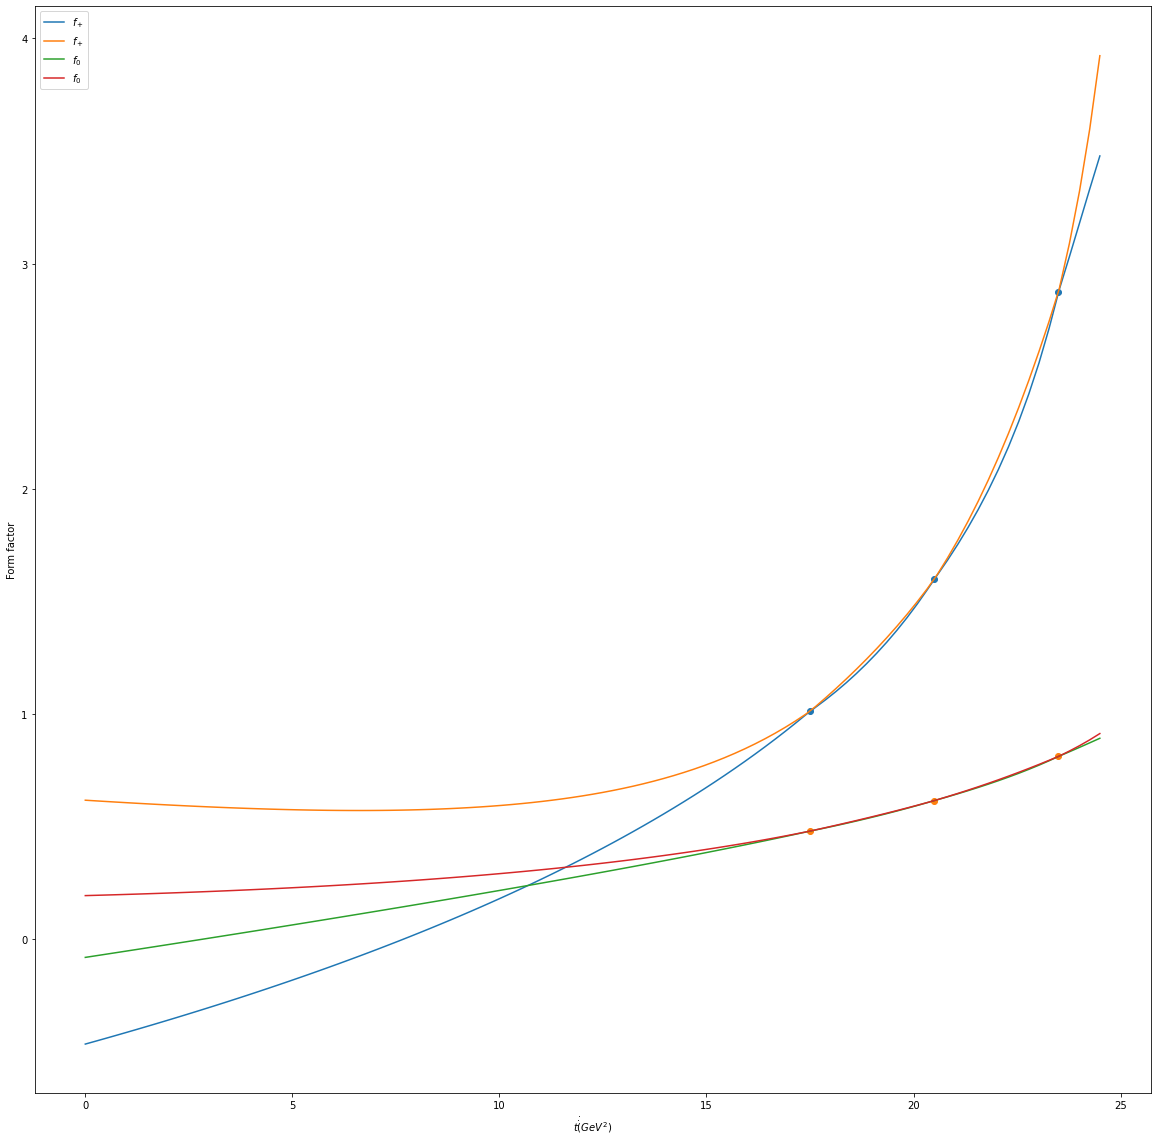

In [24]:
x = np.linspace(0,maxplott,101)
resampleddata = covresample(bskpts)
plt.plot(x,[formfactor(resampleddata,i)[1] for i in x],label = r"$f_+$")
plt.plot(x,[formfactor(resampleddata,i)[0] for i in x],label = r"$f_0$")
plt.scatter(resampleddata[1][:,0],resampleddata[1][:,1])
plt.scatter(resampleddata[0][:,0],resampleddata[0][:,1])

plt.xlabel(r"$t \.\.(GeV^2)$")
plt.ylabel("Form factor")
plt.legend()
plt.rcParams["figure.figsize"] = (20,20)
plt.show()

In [30]:
#investigating index
#np.random.seed(seed=1)
NBoot = 100
N0 = 4
tlist = [0.5]
output = dispbounds(tlist,NBoot,N0=N0,keepallindexresults=True)#,seed=2

100%|██████████| 100/100 [00:04<00:00, 20.02it/s]


No handles with labels found to put in legend.


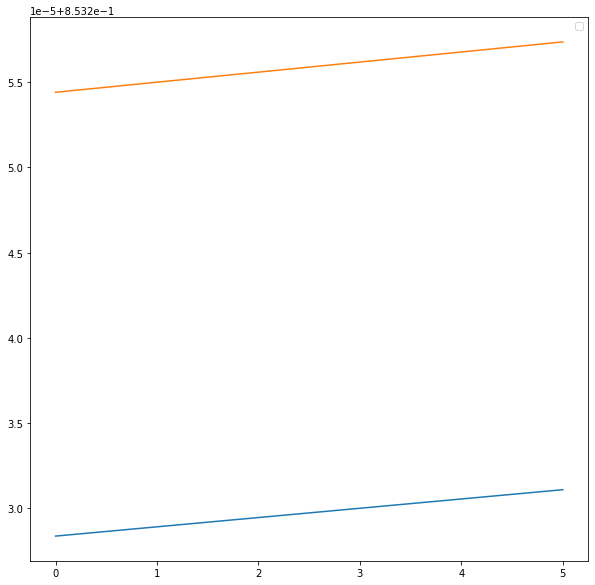

In [162]:
for t in range(len(tlist)):
    for x in range(NBoot):
        for bound in [0,1]:
            plt.plot(range(6),[output[1][x][t][i][fftoplot][bound] for i in range(6)])#,label=str(t)/output[1][x][t][99][fftoplot][bound]

#plt.xlabel(r"$t \.\.(GeV^2)$")
#plt.ylabel("Form factor")
plt.legend()
plt.rcParams["figure.figsize"] = (10,10)
plt.show()

No handles with labels found to put in legend.


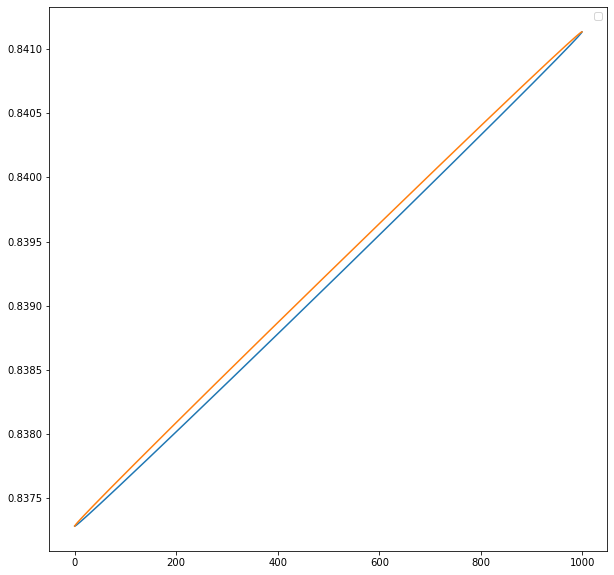

In [335]:
fftoplot = 1 #0=f0, 1 = f+
N0plotrange = range(N0)
for t in range(len(tlist)):
    for x in range(NBoot):
        for bound in [0,1]:
            plt.plot(N0plotrange,[output[1][x][t][i][fftoplot][bound] for i in N0plotrange])#,label=str(t)/output[1][x][t][0][fftoplot][bound]

#plt.xlabel(r"$t \.\.(GeV^2)$")
#plt.ylabel("Form factor")
plt.legend()
plt.rcParams["figure.figsize"] = (10,10)
plt.show()

In [180]:
#investigating index
#np.random.seed(seed=1)
NBoot = 25
N0 = 10
tlist = [0]
output = dispbounds(tlist,NBoot,N0=N0,keepallindexresults=True)#,seed=2


  4%|▍         | 1/25 [00:00<00:04,  5.39it/s]

No Overlap
No Overlap
No Overlap


 32%|███▏      | 8/25 [00:00<00:02,  5.82it/s]

discriminant is negative:  -10242560.5 -17592186044416.0
discriminant is negative:  -8579970.0 -52776558133248.0


 68%|██████▊   | 17/25 [00:02<00:01,  5.04it/s]

discriminant is negative:  -6461186.5 -17592186044416.0


100%|██████████| 25/25 [00:04<00:00,  5.94it/s]

No Overlap
4 0


100%|██████████| 100/100 [11:51<00:00,  7.12s/it]


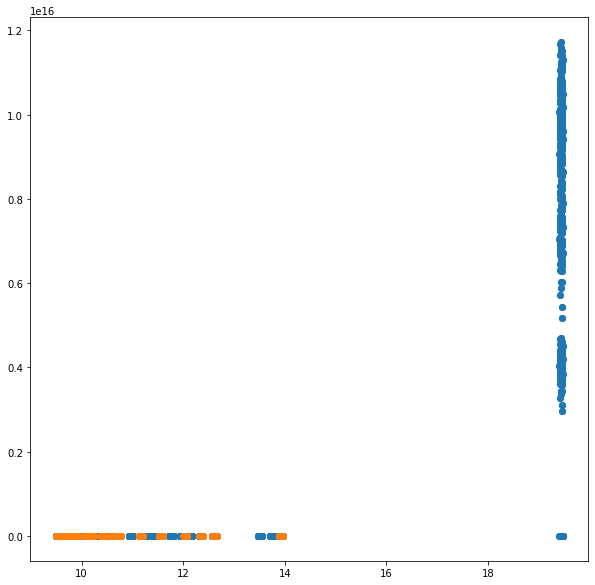

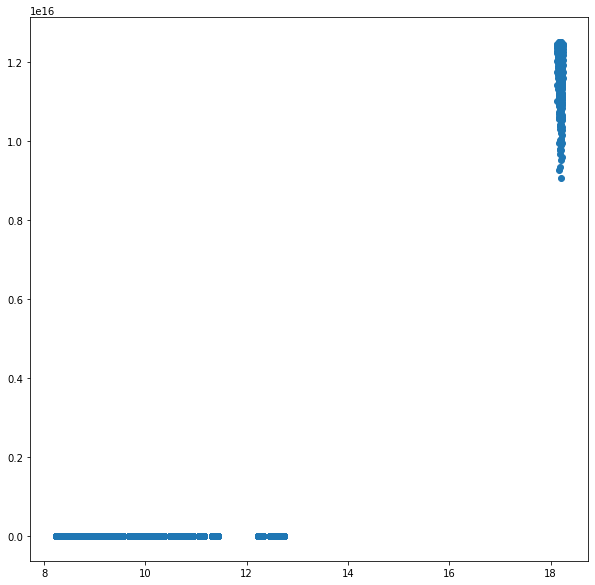

In [327]:
timelist = np.linspace(0,maxplott,51)#[10]#[17.5,21.15623588,23.72835562]
NBootstraps = 100
output = dispbounds(timelist,NBootstraps,N0=10)

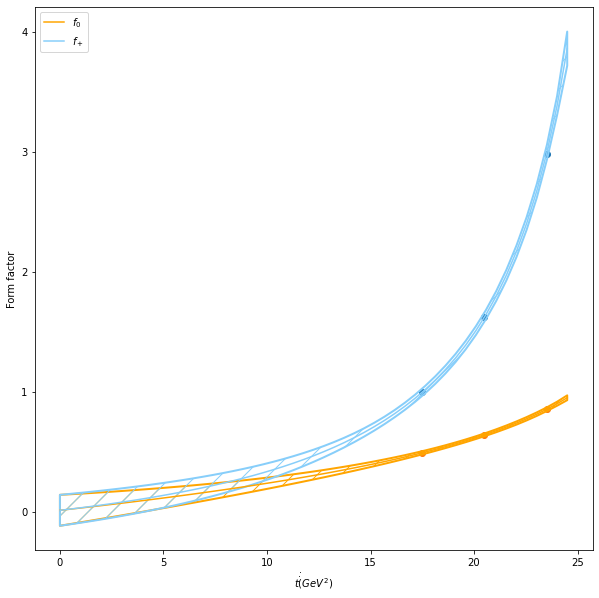

In [328]:
final = calcbounds(output)
tvals = final[0]
f0vals = final[1]
f0vars = final[2]
fplusvals = final[3]
fplusvars = final[4]


plt.scatter(dataplus[:,0],dataplus[:,1])
plt.scatter(datazero[:,0],datazero[:,1])
plt.plot(tvals,f0vals,label = r"$f_0$",color="orange")
plt.fill_between(tvals,f0vals-f0vars,f0vals+f0vars,linewidth=2,hatch='/',edgecolor="orange",facecolor="none")
plt.plot(tvals,fplusvals,label = r"$f_+$",color="lightskyblue")
plt.fill_between(tvals,fplusvals-fplusvars,fplusvals+fplusvars,linewidth=2,hatch='/',edgecolor="lightskyblue",facecolor="none")

plt.xlabel(r"$t \.\. (GeV^2)$")
plt.ylabel("Form factor")
plt.legend()
plt.rcParams["figure.figsize"] = (25,15)
plt.show()

In [29]:
returnsdatacheck = dispbounds([17.5,21.15623588,23.72835562],1000,N0=10)

100%|██████████| 1000/1000 [05:53<00:00,  2.83it/s]


In [30]:
calcbounds(returnsdatacheck)

[array([17.5       , 21.15623588, 23.72835562]),
 array([0.49073852, 0.68062627, 0.87563143]),
 array([0.01326492, 0.01222014, 0.01536583]),
 array([0.98398847, 1.82439002, 3.17116855]),
 array([0.0313344 , 0.04100632, 0.06543655])]